In [ ]:
# CELL 1 – Setup & Import Libraries
# Penjelasan:
# - Install (opsional) dan import library yang dibutuhkan.
# - Set random seed agar eksperimen bisa direproduksi.

!pip install -q tensorflow==2.15.0

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess

from sklearn.metrics import classification_report, confusion_matrix

# Set seed untuk reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow version:", tf.__version__)

ERROR: Could not find a version that satisfies the requirement tensorflow==2.15.0 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.15.0
TensorFlow version: 2.19.0


In [ ]:
# CELL 2 – Mount Google Drive & Load Dataset
# Penjelasan:
# - Mount Google Drive.
# - Set path dataset (train, val, test).
# - Verifikasi struktur folder.

from google.colab import drive
drive.mount('/content/drive')

BASE_DIR = '/content/drive/MyDrive/FishImgDataset'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VAL_DIR   = os.path.join(BASE_DIR, 'val')
TEST_DIR  = os.path.join(BASE_DIR, 'test')

print("Train dir:", TRAIN_DIR)
print("Val dir  :", VAL_DIR)
print("Test dir :", TEST_DIR)

print("\nKelas di train:")
print(os.listdir(TRAIN_DIR))

print("\nContoh beberapa file dari salah satu kelas:")
sample_class = os.listdir(TRAIN_DIR)[0]
sample_class_path = os.path.join(TRAIN_DIR, sample_class)
print("Kelas contoh:", sample_class)
print(os.listdir(sample_class_path)[:5])

Mounted at /content/drive
Train dir: /content/drive/MyDrive/FishImgDataset/train
Val dir  : /content/drive/MyDrive/FishImgDataset/val
Test dir : /content/drive/MyDrive/FishImgDataset/test

Kelas di train:
['Silver Perch', 'Scat Fish', 'Tenpounder', 'Pangasius', 'Snakehead', 'Silver Carp', 'Tilapia', 'Silver Barb', 'Perch', 'Indo-Pacific Tarpon', 'Knifefish', 'Mosquito Fish', 'Jaguar Gapote', 'Indian Carp', 'Green Spotted Puffer', 'Long-Snouted Pipefish', 'Mudfish', 'Mullet', 'Janitor Fish', 'Black Spotted Barb', 'Gold Fish', 'Glass Perchlet', 'Freshwater Eel', 'Catfish', 'Grass Carp', 'Goby', 'Fourfinger Threadfin', 'Gourami', 'Climbing Perch', 'Bangus', 'Big Head Carp']

Contoh beberapa file dari salah satu kelas:
Kelas contoh: Silver Perch
['Picture100.jpg', 'Picture120.jpg', 'Picture121.jpg', 'Picture114.jpg', 'Picture109.jpg']


Jumlah gambar per kelas (train):
{'Bangus': 171, 'Big Head Carp': 201, 'Black Spotted Barb': 200, 'Catfish': 314, 'Climbing Perch': 152, 'Fourfinger Threadfin': 191, 'Freshwater Eel': 271, 'Glass Perchlet': 397, 'Goby': 607, 'Gold Fish': 206, 'Gourami': 311, 'Grass Carp': 1222, 'Green Spotted Puffer': 110, 'Indian Carp': 262, 'Indo-Pacific Tarpon': 186, 'Jaguar Gapote': 229, 'Janitor Fish': 286, 'Knifefish': 319, 'Long-Snouted Pipefish': 256, 'Mosquito Fish': 254, 'Mudfish': 189, 'Mullet': 174, 'Pangasius': 193, 'Perch': 293, 'Scat Fish': 154, 'Silver Barb': 329, 'Silver Carp': 238, 'Silver Perch': 283, 'Snakehead': 232, 'Tenpounder': 277, 'Tilapia': 294}

Jumlah gambar per kelas (val):
{'Bangus': 52, 'Big Head Carp': 63, 'Black Spotted Barb': 63, 'Catfish': 97, 'Climbing Perch': 48, 'Fourfinger Threadfin': 60, 'Freshwater Eel': 84, 'Glass Perchlet': 124, 'Goby': 189, 'Gold Fish': 65, 'Gourami': 97, 'Grass Carp': 378, 'Green Spotted Puffer': 34, 'Indian Carp': 81, 'Indo-Pacific Tarpon'

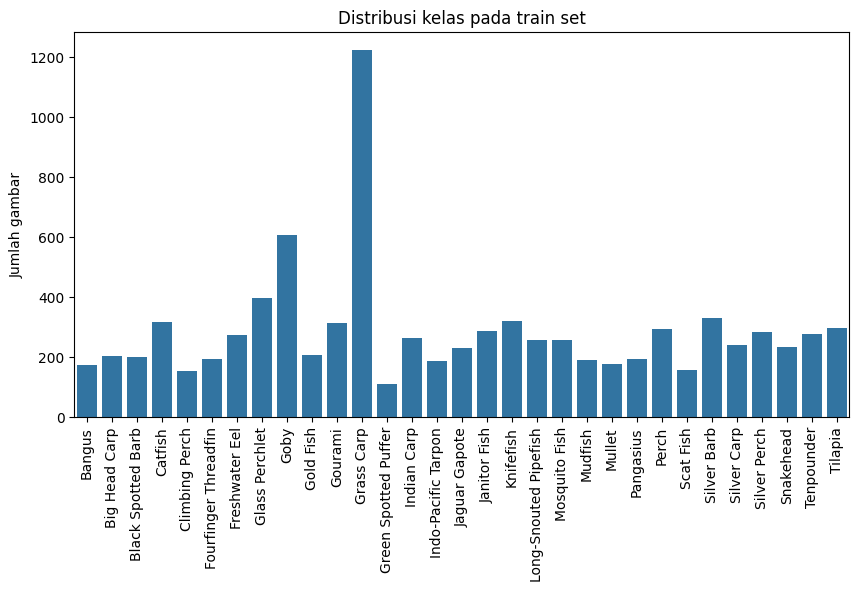

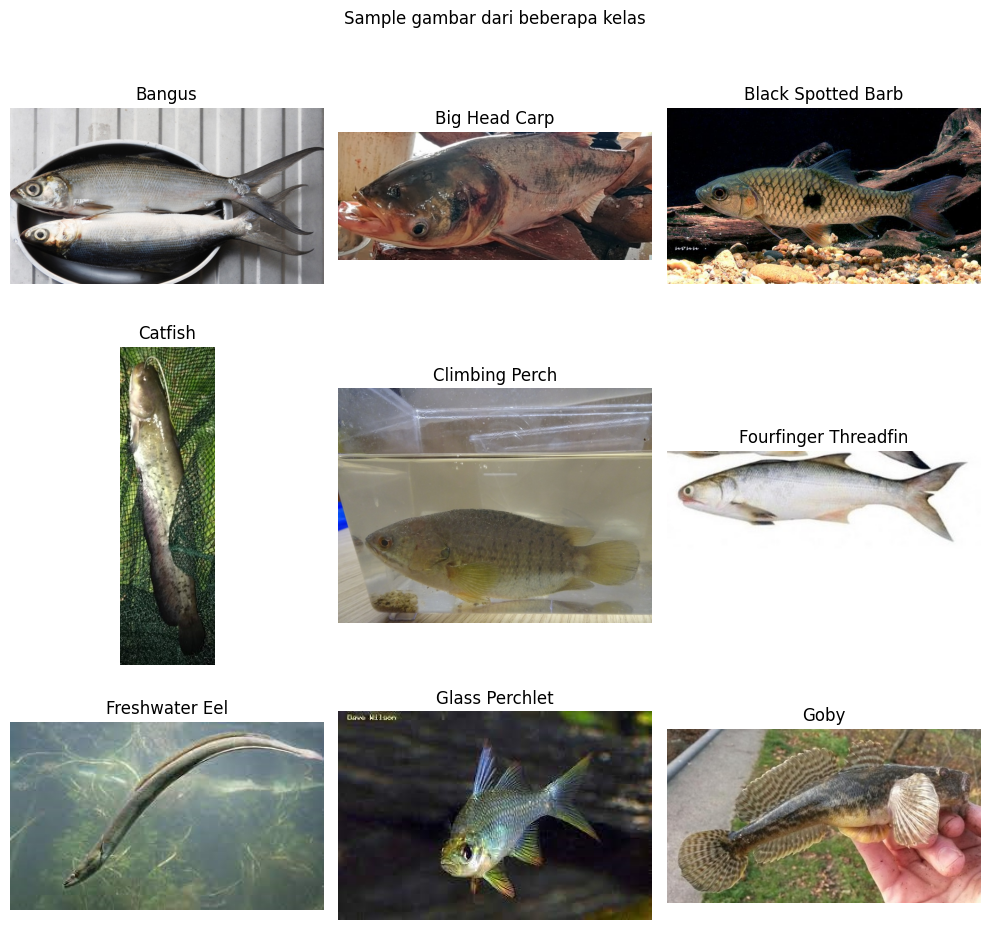

Rata-rata ukuran gambar (train): 583.7 x 398.3
Min ukuran: 92 x 71
Max ukuran: 5184 x 3456


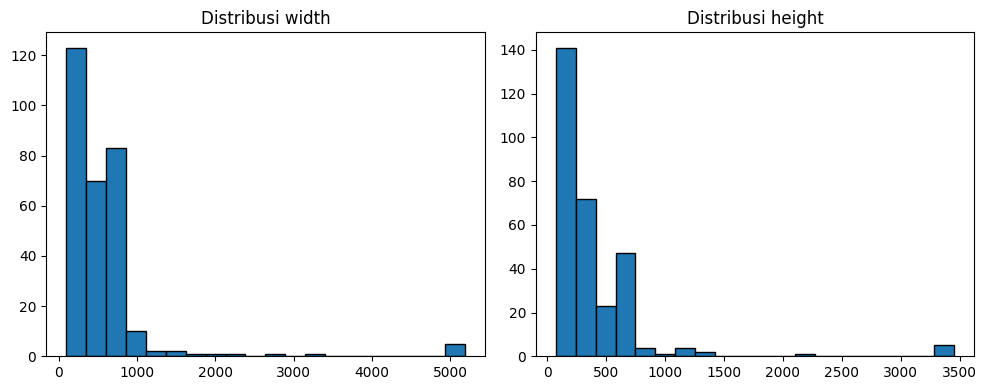

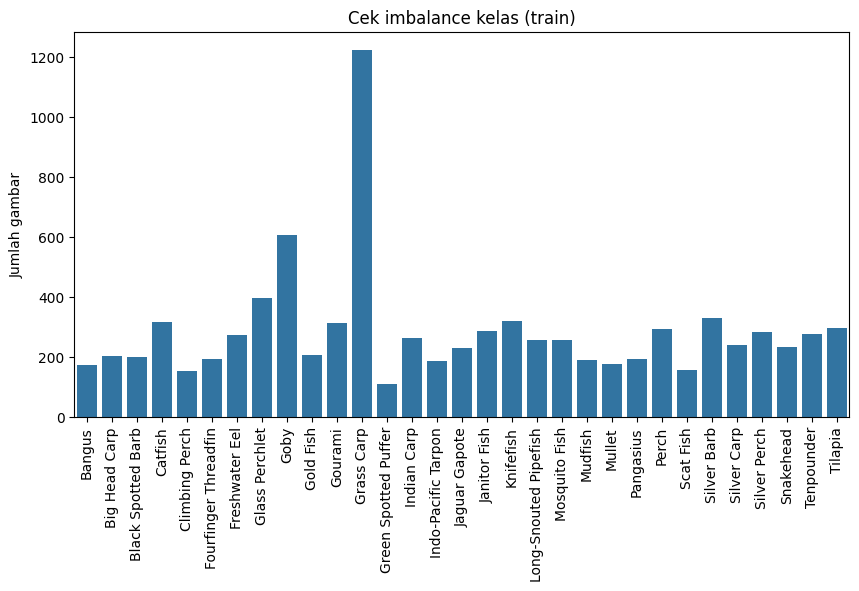

In [ ]:
# CELL 3 – EDA: distribusi kelas & sample gambar
# Penjelasan:
# - Hitung jumlah gambar per kelas di train/val/test.
# - Visualisasi distribusi kelas.
# - Tampilkan sample gambar per kelas.
# - Analisis sederhana resolusi gambar.

from PIL import Image

def count_images_per_class(directory):
    class_counts = {}
    for cls in sorted(os.listdir(directory)):
        cls_path = os.path.join(directory, cls)
        if os.path.isdir(cls_path):
            class_counts[cls] = len([
                f for f in os.listdir(cls_path)
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))
            ])
    return class_counts

train_counts = count_images_per_class(TRAIN_DIR)
val_counts   = count_images_per_class(VAL_DIR)
test_counts  = count_images_per_class(TEST_DIR)

print("Jumlah gambar per kelas (train):")
print(train_counts)
print("\nJumlah gambar per kelas (val):")
print(val_counts)
print("\nJumlah gambar per kelas (test):")
print(test_counts)

# Bar chart distribusi kelas train
plt.figure(figsize=(10, 5))
sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()))
plt.xticks(rotation=90)
plt.title("Distribusi kelas pada train set")
plt.ylabel("Jumlah gambar")
plt.show()

# Tampilkan sample gambar dari beberapa kelas (grid)
num_classes_to_show = min(9, len(train_counts))
selected_classes = list(train_counts.keys())[:num_classes_to_show]

plt.figure(figsize=(10, 10))
for i, cls in enumerate(selected_classes):
    cls_path = os.path.join(TRAIN_DIR, cls)
    img_name = random.choice(os.listdir(cls_path))
    img_path = os.path.join(cls_path, img_name)

    img = Image.open(img_path).convert("RGB")
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')
plt.suptitle("Sample gambar dari beberapa kelas")
plt.tight_layout()
plt.show()

# Analisis resolusi gambar (ambil sampel acak)
def analyze_image_sizes(directory, num_samples=200):
    widths, heights = [], []
    all_paths = []
    for cls in os.listdir(directory):
        cls_path = os.path.join(directory, cls)
        if os.path.isdir(cls_path):
            for f in os.listdir(cls_path):
                if f.lower().endswith(('.jpg', '.jpeg', '.png')):
                    all_paths.append(os.path.join(cls_path, f))

    random.shuffle(all_paths)
    sample_paths = all_paths[:min(num_samples, len(all_paths))]

    for p in sample_paths:
        with Image.open(p) as img:
            w, h = img.size
            widths.append(w)
            heights.append(h)
    return widths, heights

widths, heights = analyze_image_sizes(TRAIN_DIR, num_samples=300)
print(f"Rata-rata ukuran gambar (train): {np.mean(widths):.1f} x {np.mean(heights):.1f}")
print(f"Min ukuran: {np.min(widths)} x {np.min(heights)}")
print(f"Max ukuran: {np.max(widths)} x {np.max(heights)}")

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(widths, bins=20, edgecolor='black')
plt.title("Distribusi width")
plt.subplot(1,2,2)
plt.hist(heights, bins=20, edgecolor='black')
plt.title("Distribusi height")
plt.tight_layout()
plt.show()

# Cek class imbalance (train)
plt.figure(figsize=(10,5))
sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()))
plt.xticks(rotation=90)
plt.title("Cek imbalance kelas (train)")
plt.ylabel("Jumlah gambar")
plt.show()

In [ ]:
# CELL 4 – Data Preprocessing & Augmentation
# Penjelasan:
# - Menentukan image_size dan batch_size.
# - Membuat ImageDataGenerator untuk train (dengan augmentasi) dan val/test (hanya rescale).
# - Menggunakan flow_from_directory.

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

num_classes = train_generator.num_classes
class_indices = train_generator.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}

print("\nClass indices:", class_indices)
print("Jumlah kelas:", num_classes)

Found 8801 images belonging to 31 classes.
Found 2751 images belonging to 31 classes.
Found 1760 images belonging to 31 classes.

Class indices: {'Bangus': 0, 'Big Head Carp': 1, 'Black Spotted Barb': 2, 'Catfish': 3, 'Climbing Perch': 4, 'Fourfinger Threadfin': 5, 'Freshwater Eel': 6, 'Glass Perchlet': 7, 'Goby': 8, 'Gold Fish': 9, 'Gourami': 10, 'Grass Carp': 11, 'Green Spotted Puffer': 12, 'Indian Carp': 13, 'Indo-Pacific Tarpon': 14, 'Jaguar Gapote': 15, 'Janitor Fish': 16, 'Knifefish': 17, 'Long-Snouted Pipefish': 18, 'Mosquito Fish': 19, 'Mudfish': 20, 'Mullet': 21, 'Pangasius': 22, 'Perch': 23, 'Scat Fish': 24, 'Silver Barb': 25, 'Silver Carp': 26, 'Silver Perch': 27, 'Snakehead': 28, 'Tenpounder': 29, 'Tilapia': 30}
Jumlah kelas: 31


In [ ]:
# CELL 5 – Handling Class Imbalance
# Penjelasan:
# - Menghitung class_weight berdasarkan distribusi kelas di train.
# - class_weight akan dipakai saat training.

from sklearn.utils.class_weight import compute_class_weight

# train_generator.classes berisi label integer untuk setiap sample
class_weights_arr = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weight_dict = {i: w for i, w in enumerate(class_weights_arr)}

print("Class weights:")
print(class_weight_dict)

Class weights:
{0: np.float64(1.660252782493869), 1: np.float64(1.41245385973359), 2: np.float64(1.419516129032258), 3: np.float64(0.9041504006574892), 4: np.float64(1.8677843803056027), 5: np.float64(1.4864043235939874), 6: np.float64(1.0476133793596), 7: np.float64(0.7151214755830015), 8: np.float64(0.4677153637668066), 9: np.float64(1.3781709990604447), 10: np.float64(0.9128721087024168), 11: np.float64(0.23232669869595057), 12: np.float64(2.5809384164222875), 13: np.float64(1.0836000984979068), 14: np.float64(1.526361429066944), 15: np.float64(1.2397520777574307), 16: np.float64(0.9926686217008798), 17: np.float64(0.8899787642835474), 18: np.float64(1.1089969758064515), 19: np.float64(1.117729235458471), 20: np.float64(1.5021334698754054), 21: np.float64(1.631627734519837), 22: np.float64(1.4710011699816146), 23: np.float64(0.9689529891005174), 24: np.float64(1.843527440301634), 25: np.float64(0.8629277380135307), 26: np.float64(1.1928706966657632), 27: np.float64(1.003191610623504

In [ ]:
# CELL 6 – CNN dari Scratch
# Penjelasan:
# - Membangun arsitektur CNN sederhana dengan 3–4 block conv.
# - Menggunakan BatchNorm, MaxPooling, Dropout.
# - Output softmax dengan num_classes.

def build_scratch_cnn(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs, name="scratch_cnn")
    return model

scratch_model = build_scratch_cnn(input_shape=(*IMAGE_SIZE, 3), num_classes=num_classes)
scratch_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

scratch_model.summary()

Model: "scratch_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 31)             │         7,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,243,615 (50.52 MB)

 Trainable params: 13,242,655 (50.52 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
# CELL 7 – Setup Callbacks
# Penjelasan:
# - EarlyStopping untuk menghentikan saat tidak membaik.
# - ModelCheckpoint untuk menyimpan model terbaik.
# - ReduceLROnPlateau untuk menurunkan learning rate saat plateau.

checkpoint_dir = '/content/drive/MyDrive/fish_cnn_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

scratch_ckpt_path = os.path.join(checkpoint_dir, 'scratch_best.h5')

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model_checkpoint_scratch = keras.callbacks.ModelCheckpoint(
    filepath=scratch_ckpt_path,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

callbacks_scratch = [early_stopping, model_checkpoint_scratch, reduce_lr]

In [ ]:
# CELL 8 – Training CNN dari Scratch
# Penjelasan:
# - Melatih model scratch menggunakan generator.
# - Menggunakan class_weight untuk imbalance.

EPOCHS_SCRATCH = 10

steps_per_epoch = 80
validation_steps = 20

history_scratch = scratch_model.fit(
    train_generator,
    epochs=EPOCHS_SCRATCH,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks_scratch,
    class_weight=class_weight_dict,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.0464 - loss: 11.6041 
Epoch 1: val_loss improved from inf to 14.79858, saving model to /content/drive/MyDrive/fish_cnn_checkpoints/scratch_best.h5


80/80 ━━━━━━━━━━━━━━━━━━━━ 1081s 13s/step - accuracy: 0.0463 - loss: 11.5477 - val_accuracy: 0.0219 - val_loss: 14.7986 - learning_rate: 0.0010
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.0178 - loss: 3.3954
Epoch 2: val_loss did not improve from 14.79858
80/80 ━━━━━━━━━━━━━━━━━━━━ 630s 8s/step - accuracy: 0.0178 - loss: 3.3956 - val_accuracy: 0.0219 - val_loss: 17.7323 - learning_rate: 0.0010
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.0265 - loss: 3.4518
Epoch 3: val_loss did not improve from 14.79858
80/80 ━━━━━━━━━━━━━━━━━━━━ 501s 6s/step - accuracy: 0.0265 - loss: 3.4517 - val_accuracy: 0.0250 - val_loss: 15.9910 - learning_rate: 0.0010
Epoch 4/10
36/80 ━━━━━━━━━━━━━━━━━━━━ 3:49 5s/step - accuracy: 0.0188 - loss: 3.3992

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 4: val_loss improved from 14.79858 to 13.51937, saving model to /content/drive/MyDrive/fish_cnn_checkpoints/scratch_best.h5


80/80 ━━━━━━━━━━━━━━━━━━━━ 212s 3s/step - accuracy: 0.0214 - loss: 3.4046 - val_accuracy: 0.0469 - val_loss: 13.5194 - learning_rate: 0.0010
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.0121 - loss: 3.5002
Epoch 5: val_loss improved from 13.51937 to 10.39195, saving model to /content/drive/MyDrive/fish_cnn_checkpoints/scratch_best.h5


80/80 ━━━━━━━━━━━━━━━━━━━━ 456s 6s/step - accuracy: 0.0122 - loss: 3.4997 - val_accuracy: 0.0359 - val_loss: 10.3920 - learning_rate: 0.0010
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.0204 - loss: 3.4467
Epoch 6: val_loss improved from 10.39195 to 4.77951, saving model to /content/drive/MyDrive/fish_cnn_checkpoints/scratch_best.h5


80/80 ━━━━━━━━━━━━━━━━━━━━ 427s 5s/step - accuracy: 0.0205 - loss: 3.4463 - val_accuracy: 0.0547 - val_loss: 4.7795 - learning_rate: 0.0010
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.0293 - loss: 3.4166
Epoch 7: val_loss improved from 4.77951 to 4.07235, saving model to /content/drive/MyDrive/fish_cnn_checkpoints/scratch_best.h5


80/80 ━━━━━━━━━━━━━━━━━━━━ 419s 5s/step - accuracy: 0.0292 - loss: 3.4169 - val_accuracy: 0.0219 - val_loss: 4.0724 - learning_rate: 0.0010
Epoch 8/10
36/80 ━━━━━━━━━━━━━━━━━━━━ 3:42 5s/step - accuracy: 0.0161 - loss: 3.5747
Epoch 8: val_loss improved from 4.07235 to 3.77841, saving model to /content/drive/MyDrive/fish_cnn_checkpoints/scratch_best.h5


80/80 ━━━━━━━━━━━━━━━━━━━━ 209s 3s/step - accuracy: 0.0187 - loss: 3.5390 - val_accuracy: 0.0109 - val_loss: 3.7784 - learning_rate: 0.0010
Epoch 9/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.0239 - loss: 3.4482
Epoch 9: val_loss improved from 3.77841 to 3.38005, saving model to /content/drive/MyDrive/fish_cnn_checkpoints/scratch_best.h5


80/80 ━━━━━━━━━━━━━━━━━━━━ 436s 5s/step - accuracy: 0.0239 - loss: 3.4486 - val_accuracy: 0.0047 - val_loss: 3.3800 - learning_rate: 0.0010
Epoch 10/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.0145 - loss: 3.3973
Epoch 10: val_loss did not improve from 3.38005
80/80 ━━━━━━━━━━━━━━━━━━━━ 439s 5s/step - accuracy: 0.0145 - loss: 3.3975 - val_accuracy: 0.0000e+00 - val_loss: 3.4360 - learning_rate: 0.0010


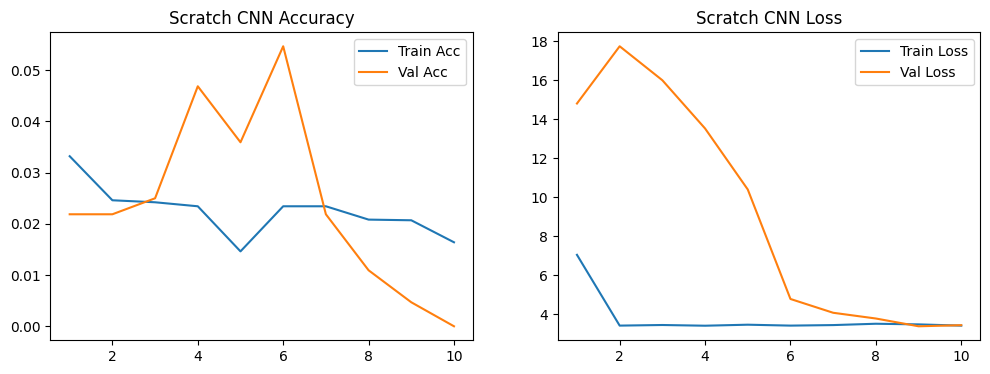

In [ ]:
# CELL 9 – Visualisasi Training History (CNN Scratch)
# Penjelasan:
# - Plot akurasi dan loss train vs val.

def plot_history(history, title_prefix=""):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(1, len(acc)+1)

    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(epochs_range, acc, label='Train Acc')
    plt.plot(epochs_range, val_acc, label='Val Acc')
    plt.legend()
    plt.title(f'{title_prefix} Accuracy')

    plt.subplot(1,2,2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.legend()
    plt.title(f'{title_prefix} Loss')

    plt.show()

plot_history(history_scratch, title_prefix="Scratch CNN")

In [ ]:
# CELL 10 – Transfer Learning Setup (MobileNetV2)
# Penjelasan:
# - Load MobileNetV2 pre-trained ImageNet tanpa top.
# - Freeze base model.
# - Tambah classification head.

base_model = MobileNetV2(
    input_shape=(*IMAGE_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False  # freeze

inputs = keras.Input(shape=(*IMAGE_SIZE, 3))
x = mobilenet_preprocess(inputs)  # preprocessing khusus MobileNetV2
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

tl_model = keras.Model(inputs, outputs, name="mobilenetv2_fish")

tl_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

tl_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "mobilenetv2_fish"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 31)             │         7,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,593,887 (9.89 MB)

 Trainable params: 335,903 (1.28 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# CELL 11 – Training Transfer Learning Model (feature extractor)
# Penjelasan:
# - Train hanya head (base model frozen).
# - Menggunakan callbacks dan class_weight.

tl_ckpt_path = os.path.join(checkpoint_dir, 'tl_best.h5')

model_checkpoint_tl = keras.callbacks.ModelCheckpoint(
    filepath=tl_ckpt_path,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

callbacks_tl = [early_stopping, model_checkpoint_tl, reduce_lr]

EPOCHS_TL = 25

history_tl = tl_model.fit(
    train_generator,
    epochs=EPOCHS_TL,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks_tl,
    class_weight=class_weight_dict,
    verbose=1
)

Epoch 1/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0302 - loss: 3.9532
Epoch 1: val_loss improved from inf to 3.50168, saving model to /content/drive/MyDrive/fish_cnn_checkpoints/tl_best.h5


80/80 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.0302 - loss: 3.9519 - val_accuracy: 0.0000e+00 - val_loss: 3.5017 - learning_rate: 1.0000e-04
Epoch 2/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0338 - loss: 3.6428
Epoch 2: val_loss improved from 3.50168 to 3.47694, saving model to /content/drive/MyDrive/fish_cnn_checkpoints/tl_best.h5


80/80 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.0338 - loss: 3.6422 - val_accuracy: 0.0000e+00 - val_loss: 3.4769 - learning_rate: 1.0000e-04
Epoch 3/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0291 - loss: 3.5458
Epoch 3: val_loss improved from 3.47694 to 3.46324, saving model to /content/drive/MyDrive/fish_cnn_checkpoints/tl_best.h5


80/80 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.0291 - loss: 3.5460 - val_accuracy: 0.0000e+00 - val_loss: 3.4632 - learning_rate: 1.0000e-04
Epoch 4/25
36/80 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.0347 - loss: 3.4470
Epoch 4: val_loss improved from 3.46324 to 3.42217, saving model to /content/drive/MyDrive/fish_cnn_checkpoints/tl_best.h5


80/80 ━━━━━━━━━━━━━━━━━━━━ 63s 780ms/step - accuracy: 0.0371 - loss: 3.4634 - val_accuracy: 0.0641 - val_loss: 3.4222 - learning_rate: 1.0000e-04
Epoch 5/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0258 - loss: 3.4802
Epoch 5: val_loss improved from 3.42217 to 3.41473, saving model to /content/drive/MyDrive/fish_cnn_checkpoints/tl_best.h5


80/80 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.0259 - loss: 3.4801 - val_accuracy: 0.0000e+00 - val_loss: 3.4147 - learning_rate: 1.0000e-04
Epoch 6/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0328 - loss: 3.5626
Epoch 6: val_loss did not improve from 3.41473
80/80 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.0328 - loss: 3.5622 - val_accuracy: 0.0000e+00 - val_loss: 3.4356 - learning_rate: 1.0000e-04
Epoch 7/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0271 - loss: 3.4022
Epoch 7: val_loss did not improve from 3.41473
80/80 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.0271 - loss: 3.4031 - val_accuracy: 0.0000e+00 - val_loss: 3.4358 - learning_rate: 1.0000e-04
Epoch 8/25
36/80 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.0274 - loss: 3.3704
Epoch 8: val_loss did not improve from 3.41473
80/80 ━━━━━━━━━━━━━━━━━━━━ 65s 804ms/step - accuracy: 0.0309 - loss: 3.4080 - val_accuracy: 0.0000e+00 - val_loss: 3.4360 - learning_rate: 1.0000e-04
Epoch 9/25
80/8

In [ ]:
# CELL 12 – Fine-tuning beberapa layer terakhir MobileNetV2
# Penjelasan:
# - Unfreeze beberapa layer terakhir.
# - Learning rate kecil.

fine_tune_at = 100  # unfreeze dari layer ke-100 ke atas (sesuaikan jika perlu)

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

tl_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

EPOCHS_FT = 10

history_ft = tl_model.fit(
    train_generator,
    epochs=EPOCHS_FT,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks_tl,
    class_weight=class_weight_dict,
    verbose=1
)

Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0278 - loss: 3.5446
Epoch 1: val_loss did not improve from 3.41473
80/80 ━━━━━━━━━━━━━━━━━━━━ 176s 2s/step - accuracy: 0.0278 - loss: 3.5445 - val_accuracy: 0.0234 - val_loss: 3.4183 - learning_rate: 1.0000e-05
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0446 - loss: 3.4187
Epoch 2: val_loss did not improve from 3.41473
80/80 ━━━━━━━━━━━━━━━━━━━━ 203s 3s/step - accuracy: 0.0445 - loss: 3.4186 - val_accuracy: 0.0688 - val_loss: 3.4265 - learning_rate: 1.0000e-05
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0406 - loss: 3.4769
Epoch 3: val_loss did not improve from 3.41473
80/80 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.0406 - loss: 3.4764 - val_accuracy: 0.0000e+00 - val_loss: 3.4528 - learning_rate: 1.0000e-05
Epoch 4/10
36/80 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - accuracy: 0.0490 - loss: 3.3338
Epoch 4: val_loss did not improve from 3.41473
80/80 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - a

80/80 ━━━━━━━━━━━━━━━━━━━━ 204s 3s/step - accuracy: 0.0512 - loss: 3.4258 - val_accuracy: 0.1234 - val_loss: 3.4063 - learning_rate: 5.0000e-06
Epoch 10/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0638 - loss: 3.4274
Epoch 10: val_loss improved from 3.40627 to 3.36517, saving model to /content/drive/MyDrive/fish_cnn_checkpoints/tl_best.h5


80/80 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.0639 - loss: 3.4267 - val_accuracy: 0.1266 - val_loss: 3.3652 - learning_rate: 5.0000e-06


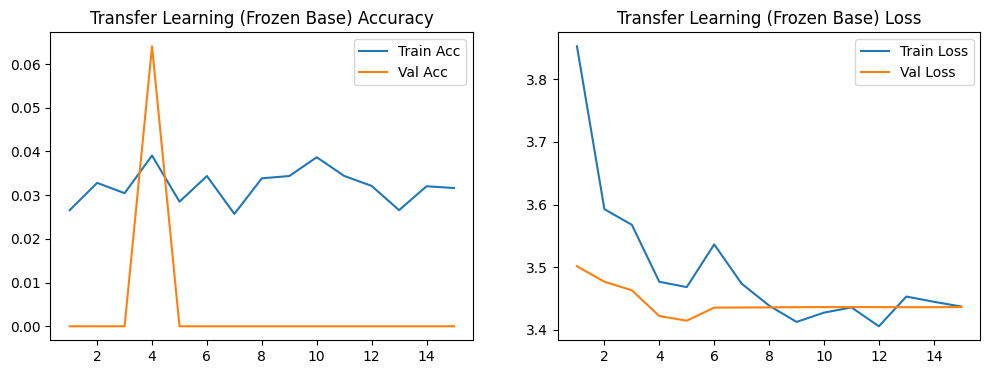

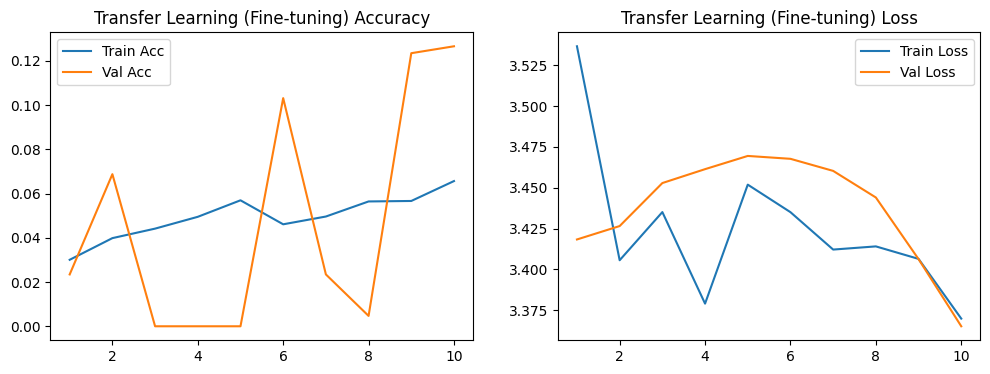

In [ ]:
# CELL 13 – Visualisasi Training History (Transfer Learning)
# Penjelasan:
# - Plot history transfer learning (dan fine-tuning jika ada).

plot_history(history_tl, title_prefix="Transfer Learning (Frozen Base)")

# Jika ada fine-tuning:
try:
    plot_history(history_ft, title_prefix="Transfer Learning (Fine-tuning)")
except NameError:
    print("Fine-tuning belum dijalankan.")

In [ ]:
# CELL 14 – Model Evaluation di Test Set (tanpa load_model)
# Penjelasan:
# - Langsung pakai objek model TL yang sudah dilatih (tl_model).
# - Evaluasi di test set.
# - Tampilkan classification report dan accuracy.

# pastikan ini nama model TL-mu, misalnya tl_model
test_loss, test_acc = tl_model.evaluate(test_generator, verbose=1)
print(f"Test Loss : {test_loss:.4f}")
print(f"Test Acc  : {test_acc:.4f}")

# Prediksi untuk classification report
test_generator.reset()
y_pred_prob = tl_model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = test_generator.classes

print("\nClassification Report:")
print(classification_report(
    y_true, y_pred,
    target_names=[idx_to_class[i] for i in range(num_classes)]
))


55/55 ━━━━━━━━━━━━━━━━━━━━ 499s 9s/step - accuracy: 0.0564 - loss: 3.3896
Test Loss : 3.4269
Test Acc  : 0.0307
55/55 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step

Classification Report:
                       precision    recall  f1-score   support

               Bangus       0.00      0.00      0.00        34
        Big Head Carp       0.00      0.00      0.00        43
   Black Spotted Barb       0.00      0.00      0.00        40
              Catfish       0.00      0.00      0.00        62
       Climbing Perch       0.00      0.00      0.00        30
 Fourfinger Threadfin       0.00      0.00      0.00        38
       Freshwater Eel       0.03      0.95      0.06        55
       Glass Perchlet       0.00      0.00      0.00        77
                 Goby       0.02      0.02      0.02       124
            Gold Fish       0.00      0.00      0.00        41
              Gourami       0.00      0.00      0.00        63
           Grass Carp       0.00      0.00      0.00       238
 Gree

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


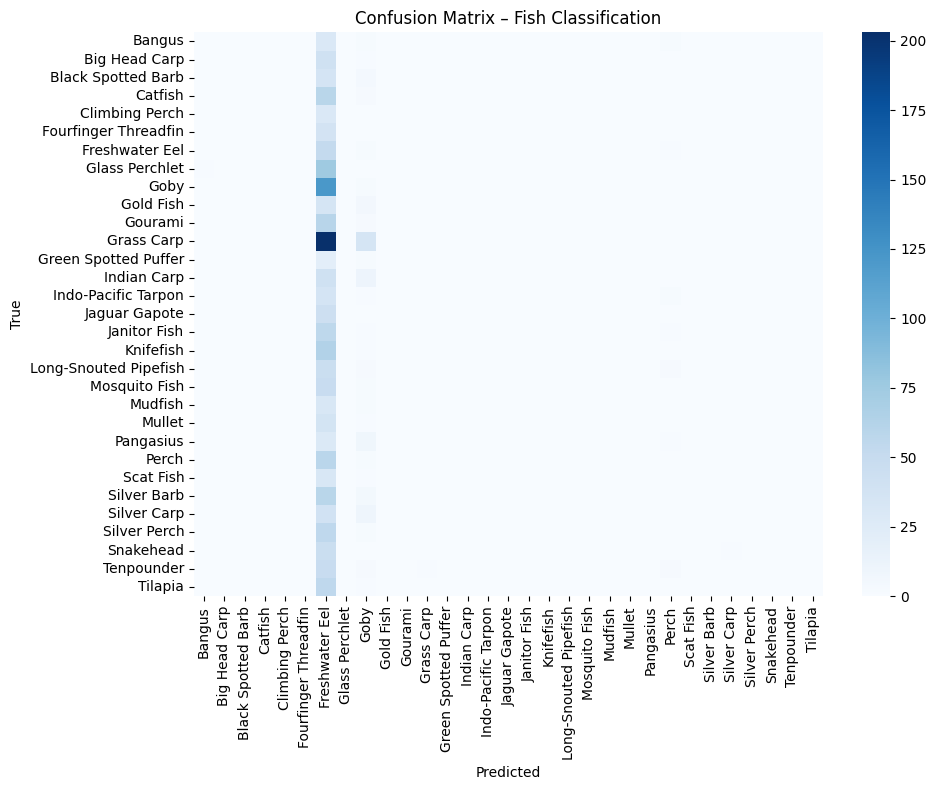

In [ ]:
# CELL 15 – Confusion Matrix
# Penjelasan:
# - Buat confusion matrix dan visualisasikan dengan heatmap.

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=False, cmap='Blues',
            xticklabels=[idx_to_class[i] for i in range(num_classes)],
            yticklabels=[idx_to_class[i] for i in range(num_classes)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix – Fish Classification')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

            Model  Best Val Acc  Best Val Loss
0     Scratch CNN      0.054688       3.380048
1  MobileNetV2 TL      0.064062       3.414727


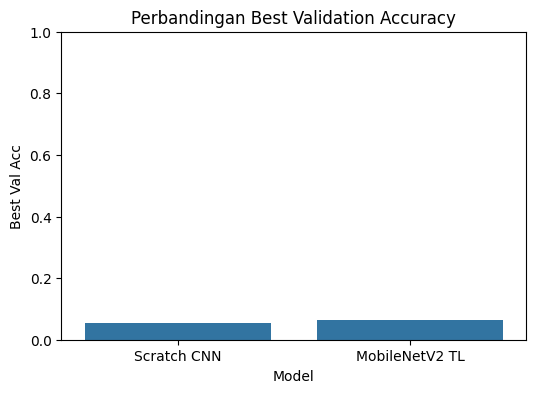


Model terbaik berdasarkan val_acc dan test_acc kemungkinan besar: MobileNetV2 TL (transfer learning).


In [ ]:
# CELL 16 – Perbandingan Model
# Penjelasan:
# - Bandingkan performa CNN scratch dan transfer learning (val accuracy / test accuracy).

# Ambil metrik akhir dari history scratch
scratch_val_acc = max(history_scratch.history['val_accuracy'])
scratch_val_loss = min(history_scratch.history['val_loss'])

# Ambil metrik akhir dari history transfer learning
tl_val_acc = max(history_tl.history['val_accuracy'])
tl_val_loss = min(history_tl.history['val_loss'])

comparison_df = pd.DataFrame([
    {
        "Model": "Scratch CNN",
        "Best Val Acc": scratch_val_acc,
        "Best Val Loss": scratch_val_loss
    },
    {
        "Model": "MobileNetV2 TL",
        "Best Val Acc": tl_val_acc,
        "Best Val Loss": tl_val_loss
    }
])

print(comparison_df)

plt.figure(figsize=(6,4))
sns.barplot(x="Model", y="Best Val Acc", data=comparison_df)
plt.title("Perbandingan Best Validation Accuracy")
plt.ylim(0,1)
plt.show()

print("\nModel terbaik berdasarkan val_acc dan test_acc kemungkinan besar: MobileNetV2 TL (transfer learning).")

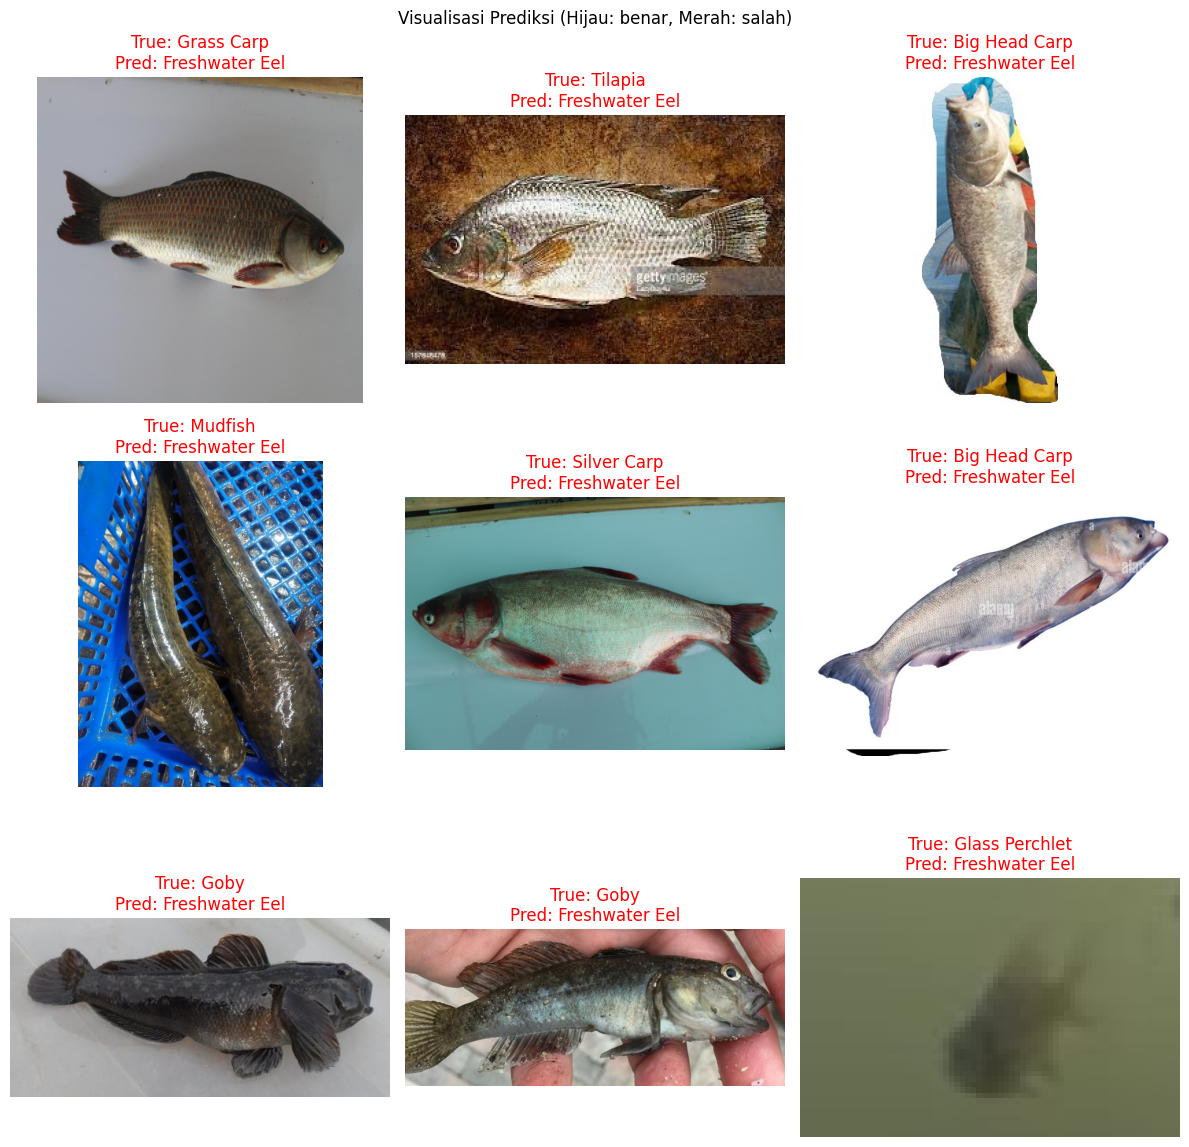

In [ ]:
# CELL 17 – Visualisasi Prediksi
# Penjelasan:
# - Tampilkan beberapa sample test dengan prediksi vs label asli.

num_samples = 9
indices = np.random.choice(len(y_true), size=num_samples, replace=False)

plt.figure(figsize=(12,12))
for i, idx in enumerate(indices):
    img_path = test_generator.filepaths[idx]
    img = Image.open(img_path).convert("RGB")
    img_resized = img.resize(IMAGE_SIZE)
    img_array = np.array(img_resized) / 255.0
    input_tensor = np.expand_dims(img_array, axis=0)

    # PAKAI tl_model (atau pastikan best_model sudah = tl_model di Cell 14)
    pred_prob = tl_model.predict(input_tensor, verbose=0)
    pred_class = np.argmax(pred_prob, axis=1)[0]

    true_label = idx_to_class[y_true[idx]]
    pred_label = idx_to_class[pred_class]

    plt.subplot(3,3,i+1)
    plt.imshow(img)
    color = 'green' if true_label == pred_label else 'red'
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
    plt.axis('off')

plt.suptitle("Visualisasi Prediksi (Hijau: benar, Merah: salah)")
plt.tight_layout()
plt.show()

Layer feature map yang divisualisasikan: ['Conv1', 'expanded_conv_project', 'block_1_expand', 'block_1_project']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


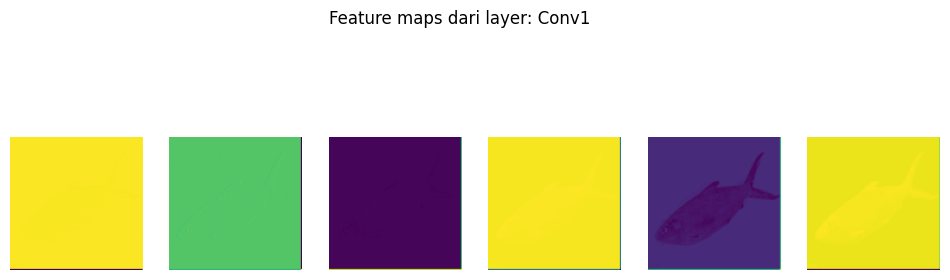

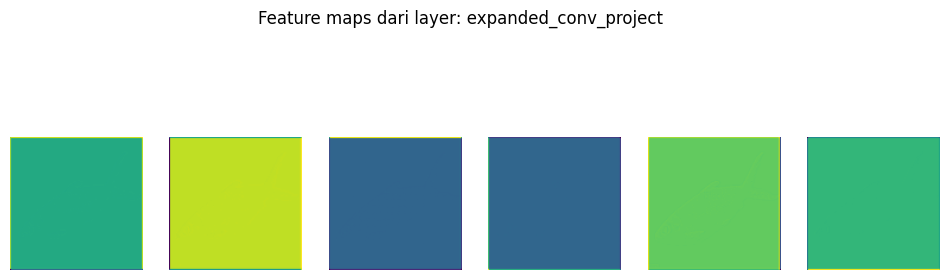

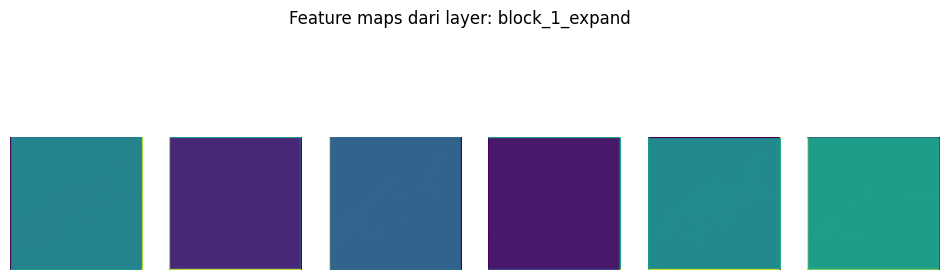

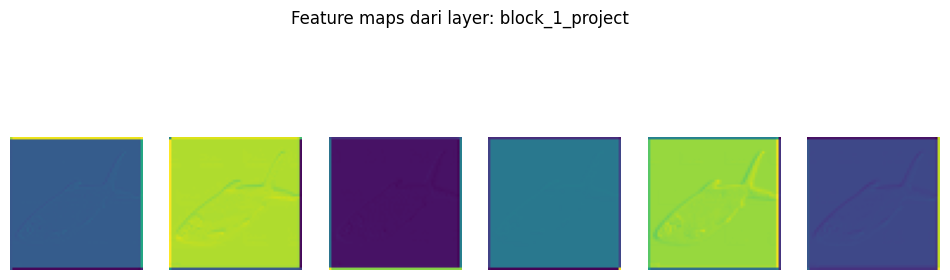

In [ ]:
# CELL 18 – CNN Visualization – Feature Maps
# Penjelasan:
# - Visualisasi feature maps dari beberapa conv layer pertama model transfer learning.

# Ambil satu sample gambar
sample_path = test_generator.filepaths[0]
img = Image.open(sample_path).convert("RGB")
img_resized = img.resize(IMAGE_SIZE)
img_array = np.array(img_resized) / 255.0
img_tensor = np.expand_dims(img_array, axis=0)

# Pilih beberapa layer conv dari base_model
conv_layer_names = [layer.name for layer in base_model.layers
                    if isinstance(layer, layers.Conv2D)][:4]

print("Layer feature map yang divisualisasikan:", conv_layer_names)

# Buat model yang outputnya adalah feature maps layer-layer ini
outputs = [base_model.get_layer(name).output for name in conv_layer_names]
feature_map_model = keras.Model(inputs=base_model.input, outputs=outputs)

# Karena tl_model pakai preprocess_input, kita harus preprocess juga
img_preprocessed = mobilenet_preprocess(img_tensor.copy())
feature_maps = feature_map_model.predict(img_preprocessed)

# Plot beberapa channel dari tiap feature map
for fmap, name in zip(feature_maps, conv_layer_names):
    num_channels_to_show = min(6, fmap.shape[-1])
    plt.figure(figsize=(12,4))
    for i in range(num_channels_to_show):
        plt.subplot(1, num_channels_to_show, i+1)
        plt.imshow(fmap[0, :, :, i], cmap='viridis')
        plt.axis('off')
    plt.suptitle(f"Feature maps dari layer: {name}")
    plt.show()

In [ ]:
# CELL 19 – Grad-CAM (Konseptual / Optional)
# Penjelasan:
# - Contoh implementasi Grad-CAM untuk model MobileNetV2.
# - Pada runtime Keras/TensorFlow di Colab ini, eksekusi dapat gagal
#   karena error internal graph, sehingga visualisasi bersifat konseptual.

import cv2
import tensorflow as tf
from tensorflow.keras import layers

try:
    # 1. Cari last conv layer di base_model
    last_conv_layer_name = None
    for layer in reversed(base_model.layers):
        if isinstance(layer, layers.Conv2D):
            last_conv_layer_name = layer.name
            break

    print("Last conv layer untuk Grad-CAM:", last_conv_layer_name)

    last_conv_layer = base_model.get_layer(last_conv_layer_name)

    # 2. Bangun model gabungan: input tl_model -> feature map + output akhir
    grad_model = tf.keras.models.Model(
        inputs=tl_model.input,
        outputs=[last_conv_layer.output, tl_model.output]
    )

    def make_gradcam_heatmap_simple(img_array_raw, grad_model, pred_index=None):
        # img_array_raw: [1, H, W, 3] dalam [0,1]
        img_array = mobilenet_preprocess(img_array_raw * 255.0)

        with tf.GradientTape() as tape:
            conv_outputs, predictions = grad_model(img_array)
            if pred_index is None:
                pred_index = tf.argmax(predictions[0])
            class_channel = predictions[:, pred_index]

        grads = tape.gradient(class_channel, conv_outputs)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        conv_outputs = conv_outputs[0]

        heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)
        heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
        return heatmap.numpy()

    # 3. Ambil satu gambar sample dari test set
    sample_path = test_generator.filepaths[0]
    img = Image.open(sample_path).convert("RGB")
    img_resized = img.resize(IMAGE_SIZE)
    img_array = np.array(img_resized) / 255.0
    img_tensor = np.expand_dims(img_array, axis=0)

    # 4. Prediksi & Grad-CAM
    preds = tl_model.predict(mobilenet_preprocess(img_tensor * 255.0), verbose=0)
    pred_class_idx = np.argmax(preds[0])

    heatmap = make_gradcam_heatmap_simple(img_tensor, grad_model, pred_index=pred_class_idx)

    # 5. Overlay heatmap
    heatmap_resized = cv2.resize(heatmap, IMAGE_SIZE)
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    superimposed_img = heatmap_color * 0.4 + (img_array * 255)
    superimposed_img = np.uint8(superimposed_img)

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title("Gambar asli")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(superimposed_img)
    plt.title("Grad-CAM overlay (sederhana)")
    plt.axis('off')
    plt.show()

except Exception as e:
    print("Grad-CAM tidak dapat dieksekusi penuh karena error internal Keras/TensorFlow:")
    print(e)
    print("\nSecara konsep, Grad-CAM digunakan untuk menyorot area gambar yang paling "
          "berkontribusi terhadap prediksi kelas ikan oleh model MobileNetV2.")

Last conv layer untuk Grad-CAM: Conv_1
Grad-CAM tidak dapat dieksekusi penuh karena error internal Keras/TensorFlow:
"Exception encountered when calling Functional.call().\n\n\x1b135105183868224\x1b\n\nArguments received by Functional.call():\n  • inputs=array([[[[1., 1., 1.],\n         [1., 1., 1.],\n         [1., 1., 1.],\n         ...,\n         [1., 1., 1.],\n         [1., 1., 1.],\n         [1., 1., 1.]],\n\n        [[1., 1., 1.],\n         [1., 1., 1.],\n         [1., 1., 1.],\n         ...,\n         [1., 1., 1.],\n         [1., 1., 1.],\n         [1., 1., 1.]],\n\n        [[1., 1., 1.],\n         [1., 1., 1.],\n         [1., 1., 1.],\n         ...,\n         [1., 1., 1.],\n         [1., 1., 1.],\n         [1., 1., 1.]],\n\n        ...,\n\n        [[1., 1., 1.],\n         [1., 1., 1.],\n         [1., 1., 1.],\n         ...,\n         [1., 1., 1.],\n         [1., 1., 1.],\n         [1., 1., 1.]],\n\n        [[1., 1., 1.],\n         [1., 1., 1.],\n         [1., 1., 1.],\n         

In [ ]:
# CELL 20 – Save Final Model & History
# Penjelasan:
# - Menyimpan model final (transfer learning) dan history training ke Drive.

import os
import json


final_model_path = os.path.join(checkpoint_dir, 'final_fish_mobilenetv2.h5')
tl_model.save(final_model_path)
print("Final model disimpan di:", final_model_path)

# Simpan history training (scratch, TL, dan fine-tuning jika ada)
history_all = {
    "scratch": history_scratch.history,
    "tl": history_tl.history
}
try:
    history_all["ft"] = history_ft.history   # kalau fine-tuning dijalankan
except NameError:
    pass

history_path = os.path.join(checkpoint_dir, 'training_history.json')
with open(history_path, 'w') as f:
    json.dump(history_all, f)

print("History training disimpan di:", history_path)

Final model disimpan di: /content/drive/MyDrive/fish_cnn_checkpoints/final_fish_mobilenetv2.h5
History training disimpan di: /content/drive/MyDrive/fish_cnn_checkpoints/training_history.json
